In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import sirtipy
from scipy.integrate import trapz

In [2]:
# In this example, you will use SiRTIPy to do frequency-dependent radiative
# transfer through thermal media. Look at the experiment1.py comments for the
# full description of how to set up a radiative transfer calculation -- the
# comments here will focus on the things that are different.

# PART A: Thermal emission.
# Let's set up a 100K thermal medium and see what the emission from it looks like.
# For simplicity, we will use an absorption coefficient that is constant,
# but an emission coefficient that depends on frequency.
#
# 1. Define the absorption coefficient function.
# FIXME: Copy your alpha_constant function here from Experiment 1.
def alpha_constant(frequency, location, Inu, alphaval):
    return alphaval

In [3]:
# 2. Now we need an emission function to go along with that which will give a
# blackbody source function. This function requires 3 extra parameters: the
# temperature of the thermal emission ("temperature"), a function that describes
# the absorption coefficient of the material ("alphafunc"), and a tuple that
# gives any extra parameters that alphafunc needs ("alphafunc_args").
# When we actually call this function, we will use alpha_constant as the
# absorption function, but in principle the j_thermal function should work for
# any absorption function.
def j_thermal(frequency, location, Inu, temperature, alphafunc, alphafunc_args):
    # FIXME: Write the emission function so that it satisfies RL equation 1.37.
    # NOTE 1: You can call the function
    #     sirtipy.blackbody_intensity(temperature, frequency)
    # to get the Planck function at the given temperature and frequency (RL
    # equation 1.51) -- you can (and should) look at how this function is defined in
    # sirtipy.py.
    # NOTE 2: To get the value of the absorption function, use
    #     alphafunc(frequency, location, Inu, *alphafunc_args)
    # return FIXME
    return alphafunc(frequency, location, Inu, *alphafunc_args) * sirtipy.blackbody_intensity(temperature, frequency)

In [140]:
# 3. Define the region and add the absorption and emission functions. Use a
# constant absorption coefficient of 1e-10 cm^-1.
medium_a = sirtipy.region()
alpha_a = 1e-10  # absorption coefficient in cm^-1
medium_temperature = 100.  # temperature of glowing medium in K
medium_a.add_absorption_func(alpha_constant, (alpha_a,))
medium_a.add_emission_func(j_thermal, (medium_temperature, alpha_constant, (alpha_a,)))

In [141]:
# 4. Define a frequency axis for the radiative transfer. The values can either
# be specified by frequency or wavelength, depending on the units that are given
# in frange. This says that we want the frequency axis to go from wavelengths of
# 1cm to 1e-6cm, and that values should be spaced logarithmically ('log').
# To space them linearly, we would say 'linear' instead of 'log'.
freqaxis = sirtipy.frequency_axis('log', frange=[1.*u.cm, 1e-6*u.cm])

In [142]:
# 5. Define the input spectrum. For this part, we are assuming no incident
# radiation, so the input spectrum is 'empty' (all values are zero).
inspec_empty = sirtipy.spectrum('empty', frequencies=freqaxis)

In [162]:
# 6. Define the axis along which the radiative transfer will go (here 0 to 3e11
# cm), and the stepsize for the finite difference equation.
s_a = [0., 3e11]
ds = 1e8

In [163]:
# 7. Calculate the radiative transfer to the final distance.
spec_a, tau_a, locations_a = sirtipy.radiative_transfer(medium_a, inspec_empty,
        s_a, ds, printevery=1000)

Location 1000 of 3000
Location 2000 of 3000
Location 3000 of 3000


/Users/meh/Desktop/programs/ay640_programs/ay640_experiment2/sirtipy.py:391: RuntimeWarning: overflow encountered in exp
  return 2. * h_over_csquared * freq**3 / (np.exp(h_over_k * freq / temperature) - 1.)


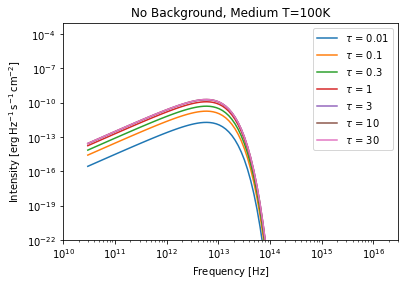

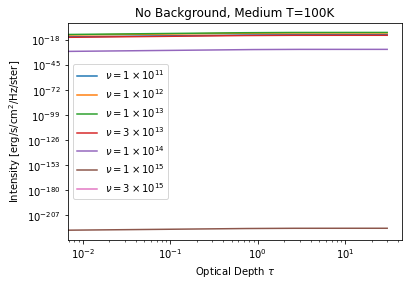

In [165]:
# Now plot the results. First, what does the intensity spectrum look like at the
# different distances?
# 1. List the distances we care about, and figure out which elements they
# correspond to in the output arrays. For example, if distances[1]=1e9, and
# los_to_plot[1]=10, then spec_a[10] is the spectrum after 1e9 cm and tau_a[10,:] is the
# optical depth spectrum after 1e9 cm.
distances = [1e8, 1e9, 3e9, 1e10, 3e10, 1e11, 3e11]
los_to_plot = np.searchsorted(locations_a, distances)
# 2. Create a figure.
plt.figure()
# 3. Loop through the different distances we care about so we can plot the
# spectrum at each point.
for l in los_to_plot:
    # This figures out how many digits after the decimal we need to write the
    # optical depth.
    digits = int(np.max([-np.floor(np.log10(tau_a[l,0])), 0]))
    # This actually plots the spectrum. If a spectrum is already plotted, this
    # overplots.
    spec_a[l].plot(xunit=u.Hz, label=('$\\tau$ = %0.'+str(digits)+'f') % tau_a[l,0])
# 4. Label the plot and make the axes logarithmic and run over a useful range.
plt.legend(loc='upper right')
plt.title('No Background, Medium T=100K')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-22, 1e-3)
plt.xlim(1e10, 3e16)
# 5. Save it to a file called 2a-spectra.png
plt.savefig('2a-spectra.png')



# Second, let's look at the radiative transfer curves through the medium, like
# we did in Experiment 1, at a few select frequencies. Note that this time we
# will use logarithmic axes, and we will use optical depth as the x-axis.
# 1. List the frequencies we care about, and figure out which elements they
# correspond to on the frequency axis. For example, if freq_to_plot[1]=1e12, and
# freq_index_to_plot[1]=26, then spec.intensities()[:,26] is the intensity
# transfer curve at 1e12 Hz.
freq_to_plot = [1e11, 1e12, 1e13, 3e13, 1e14, 1e15, 3e15]
freq_index_to_plot = np.searchsorted(freqaxis.frequencies, freq_to_plot)
# 2. Create a figure.
plt.figure()
# 3. Save the intensity array to a variable. After this, intensities_a[i,j] is
# the intensity curve a distance index i for frequency index j.
intensities_a = spec_a.intensities()
# 4. Loop through the different frequencies we care about so we can plot the
# curve for each one.
for f in freq_index_to_plot:
    # Plot optical depth vs. intensity.
    plt.plot(tau_a[:,f], intensities_a[:,f], label=('$\\nu = %s$') %
            (sirtipy.latex_float(float('%0.0e' % freqaxis.frequencies[f]))) )
# 5. Label the plot, make the axes logarithmic and run over a useful range, and
# save it.
plt.legend(loc='center left')
plt.title('No Background, Medium T=100K')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-22, 1e-3)
# plt.xlim(0.003, 30)
plt.xlabel('Optical Depth $\\tau$')
plt.ylabel('Intensity [erg/s/cm$^2$/Hz/ster]')
plt.savefig('2a-transfercurve-nolimit.png')

/Users/meh/Desktop/programs/ay640_programs/ay640_experiment2/sirtipy.py:391: RuntimeWarning: overflow encountered in exp
  return 2. * h_over_csquared * freq**3 / (np.exp(h_over_k * freq / temperature) - 1.)


Location 1000 of 3000
Location 2000 of 3000
Location 3000 of 3000


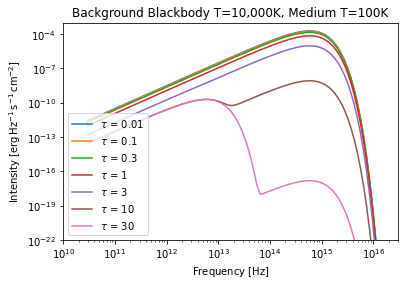

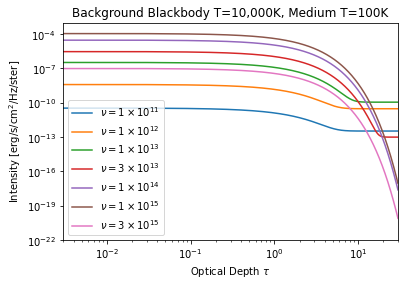

In [218]:
# PART B: Radiative transfer through a thermal medium of a background blackbody.
# Re-do Part A, but with a background spectrum that is a 10,000K blackbody.
# FIXME: Copy all of the code from Part A (you don't need the comments), but make the following changes:
# 1. Change all of the ..._a variable names to ...._b so that you have the
#    results of both versions at hand when you need them in Part C.
# 2. Use the following line to define the input spectrum of a 10,000K blackbody:
#inspec_10kK = sirtipy.spectrum('blackbody', frequencies=freqaxis, temperature=10000.)
#    and make sure to change the radiative_transfer() function call to use this input spectrum.
# 3. Change the savefig file names so you don't overwrite your plots.
# 4. Change the plot titles to something that makes sense for this experiment.
# 5. You might need to move the legends to a different corner so it doesn't
#    block interesting parts of the plot. Possible options are given at
#    http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend



medium_b = sirtipy.region()
alpha_b = 1e-10  # absorption coefficient in cm^-1
medium_temperature = 100.  # temperature of glowing medium in K
medium_b.add_absorption_func(alpha_constant, (alpha_b,))
medium_b.add_emission_func(j_thermal, (medium_temperature, alpha_constant, (alpha_b,)))

inspec_10kK = sirtipy.spectrum('blackbody', frequencies=freqaxis, temperature=10000.)

freqaxis = sirtipy.frequency_axis('log', frange=[1.*u.cm, 1e-6*u.cm])

s_b = [0., 3e11]
ds = 1e8

# 7. Calculate the radiative transfer to the final distance.
spec_b, tau_b, locations_b = sirtipy.radiative_transfer(medium_b, inspec_10kK,
                                                        s_b, ds, printevery=1000)

distances = [1e8, 1e9, 3e9, 1e10, 3e10, 1e11, 3e11]
los_to_plot = np.searchsorted(locations_b, distances)

plt.figure()

for l in los_to_plot:
    # This figures out how many digits after the decimal we need to write the
    # optical depth.
    digits = int(np.max([-np.floor(np.log10(tau_b[l,0])), 0]))
    # This actually plots the spectrum. If a spectrum is already plotted, this
    # overplots.
    spec_b[l].plot(xunit=u.Hz, label=('$\\tau$ = %0.'+str(digits)+'f') % tau_b[l,0])

plt.legend(loc='lower left')

plt.title('Background Blackbody T=10,000K, Medium T=100K')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-22, 1e-3)
plt.xlim(1e10, 3e16)

plt.savefig('2b-spectra.png')

freq_to_plot = [1e11, 1e12, 1e13, 3e13, 1e14, 1e15, 3e15]
freq_index_to_plot = np.searchsorted(freqaxis.frequencies, freq_to_plot)

plt.figure()

intensities_b = spec_b.intensities()

for f in freq_index_to_plot:
    # Plot optical depth vs. intensity.
    plt.plot(tau_b[:,f], intensities_b[:,f], label=('$\\nu = %s$') %
            (sirtipy.latex_float(float('%0.0e' % freqaxis.frequencies[f]))) )

plt.legend(loc='lower left')
plt.title('Background Blackbody T=10,000K, Medium T=100K')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-22, 1e-3)
plt.xlim(0.003, 30)
plt.xlabel('Optical Depth $\\tau$')
plt.ylabel('Intensity [erg/s/cm$^2$/Hz/ster]')
plt.savefig('2b-transfercurve.png')

/var/folders/4k/z68m9p5522jf8zn3xvx449ww0000gn/T/ipykernel_8459/1784341676.py:68: RuntimeWarning: invalid value encountered in double_scalars
  mean_emission_freq = integrated_nu_x_I / integrated_I


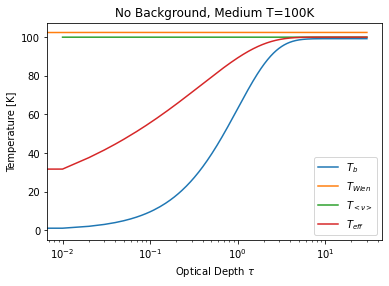

In [212]:
# PART C: Measurements of Spectral Temperature
# In this part, you will measure the brightness temperature, 2 different
# measurements of color temperature, and effective temperature of several of the
# curves.

#    1. Pick a frequency on the Rayleigh-Jeans tail for the brightness temperature.
#FIXME:
RJ_nu = (const.k_B.cgs.value / const.h.cgs.value)

#    2. Find the index on the frequency axis that corresponds to this value.
RJ_index = np.searchsorted(freqaxis.frequencies, RJ_nu)
# Since there aren't points at every single frequency point, this closest point in
# the spectrum might not be actually at RJ_nu. So we have to go make sure that RJ_nu
# actually has the correct value for this point on the spectrum.
RJ_nu = freqaxis.frequencies[RJ_index]

#    3. Define arrays to hold the PartA temperatures.
nplotdist = len(locations_a)
A_Tb = np.zeros(nplotdist)
A_TWien = np.zeros(nplotdist)
A_Tmeanfreq = np.zeros(nplotdist)
A_Teff = np.zeros(nplotdist)

#    4. Loop through the PartA spectra, and calculate the characteristic temperatures of each.
for l in range(nplotdist):
   # a) Brightness Temperature
   #    Measure I_nu at the chosen Rayliegh-Jeans frequency.
    I_nu = spec_a[l].intensity[RJ_index]
   # FIXME: Use RL 1.60 to calculate Tb. You might want to use const.c and
   # const.k_B.
   # NOTE: Because all quantities have been stored using the cgs unit system,
   # whenever you use a unit in Part C you should use the cgs value of it. For
   # example, instead of const.c use const.c.cgs.value, etc.
    A_Tb[l] = ((const.c.cgs.value**(2.0) * I_nu) / (2.0 * RJ_nu**(2.0) * const.k_B.cgs.value))

   # b) Color Temperature: Wien Displacement Law
   #    Find the point on the frequency axis where the intensity is maximized, and convert it to T_Wien.
   # argmax() returns the index where the array hits is maximum value. So, for example,
   # if intensity reaches a maximum value of 1e-4 at 1e15 Hz, and nu[80]=1e15, then 
   #     max(intensity) returns 1e-4
   #     argmax(intensity, nu) returns 80
    freqindex_max = np.argmax(spec_a[l].intensity)
   # Convert the index into an actual frequency in Hz.
    freq_max = freqaxis.frequencies[freqindex_max]
   # FIXME: Calculate the Wien displacement temperature using RL equation 1.56.
    A_TWien[l] = (const.h.cgs.value * freq_max) / (2.82 * const.k_B.cgs.value)

   # c) Color Temperature: Mean emission frequency
   #    Calculate the mean emission frequency, defined as the frequency weighted by the intensity,
   #    and then use the relation given in the experiment instructions to find the equivalent temperature
   #    for a blackbody.
   #  To do the numerical integrals:
   #        Given an array of x values "x" and an array of y values "y", you can
   #        calculate the integral of y by using the scipy.integrate.trapz function:
   #              trapz(y, x)
   #        For example, one way to calculate the integral of x^2 from 0 to 10 is:
   #        x = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
   #        y = x**2
   #        print trapz(y, x)
   #        In your case, you will want to integrate the intensity: spec_a[l].intensity
   #        and also frequency times intensity: freqaxis.frequencies * spec_a[l].intensity
   #        over the whole frequency range freqaxis.frequencies.
   # Calculate the numerator:
    integrated_nu_x_I = trapz(freqaxis.frequencies * spec_a[l].intensity, freqaxis.frequencies)
   # FIXME: Calculate the denominator, which is the integrated intensity
    integrated_I = trapz(spec_a[l].intensity, freqaxis.frequencies)
   # Use these to calculate the mean emission frequency
    mean_emission_freq = integrated_nu_x_I / integrated_I

   # FIXME: Turn this into a color temperature, as described in the experiment instructions.
   # You might want to use const.h.cgs.value and const.k_B.cgs.value for Planck's constant
   # and Boltzmann's constant respectively.
    A_Tmeanfreq[l] = (mean_emission_freq * const.h.cgs.value) / (3.83 * const.k_B.cgs.value)
   
   # d) Effective Temperature
   #    Use RL equation 1.63 to define the effective temperature.
   #    Note the Stefan-Boltzmann constant is const.sigma_sb.cgs.value.
   # Convert the integrated intensity (calculated in (c) above) to flux by assuming all
   # light is passing out through the surface, so F = pi I, as we derived in class.
    integrated_flux = np.pi * integrated_I
   # FIXME: Convert flux to effective temperature.
   #    IMPORTANT NOTE: DO NOT USE x**(1/4) to take the one-fourth power!
   #    Python will treat 1 and 4 as integers, and so it will do integer division
   #    when it divides them, and will give 0. Instead, you can either use 0.25 or
   #    you can use 1.0/4.0 to force Python to realize that they should be
   #    treated as reals instead of integers.
    A_Teff[l] = (integrated_flux / const.sigma_sb.cgs.value)**(1.0/4.0)
    
#    5. Now plot them against tau.
plt.figure()
plt.plot(tau_a[:,0], A_Tb, label='$T_b$')
plt.plot(tau_a[:,0], A_TWien, label='$T_{Wien}$')
plt.plot(tau_a[:,0], A_Tmeanfreq, label='$T_{<\\nu>}$')
plt.plot(tau_a[:,0], A_Teff, label='$T_{eff}$')
plt.legend(loc='lower right')
plt.title('No Background, Medium T=100K')
plt.xscale('log')
plt.xlabel('Optical Depth $\\tau$')
plt.ylabel('Temperature [K]')
plt.savefig('2c-a-new.png')

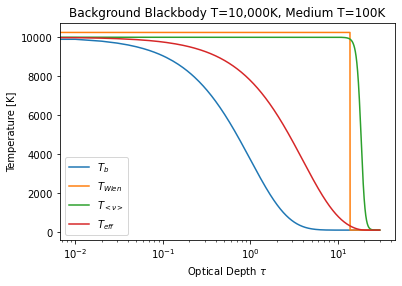

In [214]:
#    6. Do points 3 through 5 above for the PartB spectra.
# FIXME: Copy over the relevant lines from points 3, 4, and 5 (you don't need to copy the comments) and
# change them to analyze the PartB spectra instead. This will require:
#  a - renaming the A_... variables to B_...
#  b - changing the spec_a spectra to spec_b
#  c - making sure the plot has an appropriate title and filename
#  d - you might want to move the legend to the lower left

#    3. Define arrays to hold the PartA temperatures.
nplotdist = len(locations_b)
B_Tb = np.zeros(nplotdist)
B_TWien = np.zeros(nplotdist)
B_Tmeanfreq = np.zeros(nplotdist)
B_Teff = np.zeros(nplotdist)

#    4. Loop through the PartA spectra, and calculate the characteristic temperatures of each.
for l in range(nplotdist):
   # a) Brightness Temperature
   #    Measure I_nu at the chosen Rayliegh-Jeans frequency.
    I_nu_b = spec_b[l].intensity[RJ_index]
   # FIXME: Use RL 1.60 to calculate Tb. You might want to use const.c and
   # const.k_B.
   # NOTE: Because all quantities have been stored using the cgs unit system,
   # whenever you use a unit in Part C you should use the cgs value of it. For
   # example, instead of const.c use const.c.cgs.value, etc.
    B_Tb[l] = ((const.c.cgs.value**(2.0) * I_nu_b) / (2.0 * RJ_nu**(2.0) * const.k_B.cgs.value))

   # b) Color Temperature: Wien Displacement Law
   #    Find the point on the frequency axis where the intensity is maximized, and convert it to T_Wien.
   # argmax() returns the index where the array hits is maximum value. So, for example,
   # if intensity reaches a maximum value of 1e-4 at 1e15 Hz, and nu[80]=1e15, then 
   #     max(intensity) returns 1e-4
   #     argmax(intensity, nu) returns 80
    freqindex_max_b = np.argmax(spec_b[l].intensity)
   # Convert the index into an actual frequency in Hz.
    freq_max_b = freqaxis.frequencies[freqindex_max_b]
   # FIXME: Calculate the Wien displacement temperature using RL equation 1.56.
    B_TWien[l] = (const.h.cgs.value * freq_max_b) / (2.82 * const.k_B.cgs.value)

   # c) Color Temperature: Mean emission frequency
   #    Calculate the mean emission frequency, defined as the frequency weighted by the intensity,
   #    and then use the relation given in the experiment instructions to find the equivalent temperature
   #    for a blackbody.
   #  To do the numerical integrals:
   #        Given an array of x values "x" and an array of y values "y", you can
   #        calculate the integral of y by using the scipy.integrate.trapz function:
   #              trapz(y, x)
   #        For example, one way to calculate the integral of x^2 from 0 to 10 is:
   #        x = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
   #        y = x**2
   #        print trapz(y, x)
   #        In your case, you will want to integrate the intensity: spec_a[l].intensity
   #        and also frequency times intensity: freqaxis.frequencies * spec_a[l].intensity
   #        over the whole frequency range freqaxis.frequencies.
   # Calculate the numerator:
    integrated_nu_x_I_b = trapz(freqaxis.frequencies * spec_b[l].intensity, freqaxis.frequencies)
   # FIXME: Calculate the denominator, which is the integrated intensity
    integrated_I_b = trapz(spec_b[l].intensity, freqaxis.frequencies)
   # Use these to calculate the mean emission frequency
    mean_emission_freq_b = integrated_nu_x_I_b / integrated_I_b

   # FIXME: Turn this into a color temperature, as described in the experiment instructions.
   # You might want to use const.h.cgs.value and const.k_B.cgs.value for Planck's constant
   # and Boltzmann's constant respectively.
    B_Tmeanfreq[l] = (mean_emission_freq_b * const.h.cgs.value) / (3.83 * const.k_B.cgs.value)
   
   # d) Effective Temperature
   #    Use RL equation 1.63 to define the effective temperature.
   #    Note the Stefan-Boltzmann constant is const.sigma_sb.cgs.value.
   # Convert the integrated intensity (calculated in (c) above) to flux by assuming all
   # light is passing out through the surface, so F = pi I, as we derived in class.
    integrated_flux_b = np.pi * integrated_I_b
   # FIXME: Convert flux to effective temperature.
   #    IMPORTANT NOTE: DO NOT USE x**(1/4) to take the one-fourth power!
   #    Python will treat 1 and 4 as integers, and so it will do integer division
   #    when it divides them, and will give 0. Instead, you can either use 0.25 or
   #    you can use 1.0/4.0 to force Python to realize that they should be
   #    treated as reals instead of integers.
    B_Teff[l] = (integrated_flux_b / const.sigma_sb.cgs.value)**(1.0/4.0)
    
#    5. Now plot them against tau.
plt.figure()
plt.plot(tau_b[:,0], B_Tb, label='$T_b$')
plt.plot(tau_b[:,0], B_TWien, label='$T_{Wien}$')
plt.plot(tau_b[:,0], B_Tmeanfreq, label='$T_{<\\nu>}$')
plt.plot(tau_b[:,0], B_Teff, label='$T_{eff}$')
plt.legend(loc='lower left')
plt.title('Background Blackbody T=10,000K, Medium T=100K')
plt.xscale('log')
plt.xlabel('Optical Depth $\\tau$')
plt.ylabel('Temperature [K]')
plt.savefig('2c-b-new.png')

In [242]:
print('T_b A:', 'min:', np.min(A_Tb), 'max:', np.max(A_Tb))
print('T_Wien A:', 'min:', np.min(A_TWien), 'max:', np.max(A_TWien))
print('T_<v> A:', 'min:', np.nanmin(A_Tmeanfreq), 'max:', np.nanmax(A_Tmeanfreq))
print('T_eff A:', 'min:', np.min(A_Teff), 'max:', np.max(A_Teff))

print()

print('T_b B:', 'min:', np.min(B_Tb), 'max:', np.max(B_Tb))
print('T_Wien B:', 'min:', np.min(B_TWien), 'max:', np.max(B_TWien))
print('T_<v> B:', 'min:', np.min(B_Tmeanfreq), 'max:', np.max(B_Tmeanfreq))
print('T_eff B:', 'min:', np.min(B_Teff), 'max:', np.max(B_Teff))

T_b A: min: 0.0 max: 99.28233662104148
T_Wien A: min: 0.5102045664907565 max: 102.51198530526203
T_<v> A: min: 100.05822655780217 max: 100.05822655780224
T_eff A: min: 0.0 max: 100.08111969604913

T_b B: min: 99.28233662184606 max: 9999.280628814065
T_Wien B: min: 102.51198530526203 max: 10251.198530526202
T_<v> B: min: 100.13792838787427 max: 10005.82113871939
T_eff B: min: 100.08132101038956 max: 10008.112350034806


In [243]:
print(RJ_nu)

29979245799.999992


/Users/meh/Desktop/programs/ay640_programs/ay640_experiment2/sirtipy.py:391: RuntimeWarning: overflow encountered in exp
  return 2. * h_over_csquared * freq**3 / (np.exp(h_over_k * freq / temperature) - 1.)


Location 500 of 3000
Location 1000 of 3000
Location 1500 of 3000
Location 2000 of 3000
Location 2500 of 3000
Location 3000 of 3000


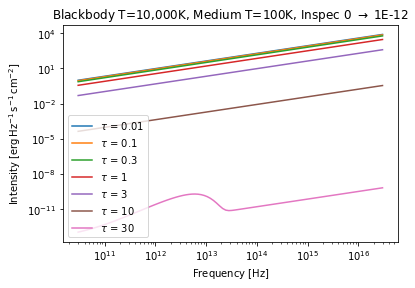

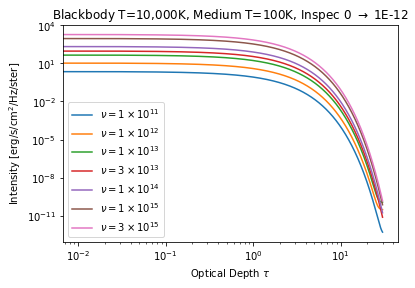

In [245]:
# Part D: Play
medium_weird = sirtipy.region()
alpha_weird = 1e-10  # absorption coefficient in cm^-1
medium_temperature = 100.  # temperature of glowing medium in K
medium_weird.add_absorption_func(alpha_constant, (alpha_weird,))
medium_weird.add_emission_func(j_thermal, (medium_temperature, alpha_constant, (alpha_weird,)))

# x = np.linspace(0, 99, num=100)

Inu_weird = np.exp(np.linspace(0, 9, num=100))

inspec_weird = sirtipy.spectrum('verbatim', frequencies=freqaxis, intensities=Inu_weird)

freqaxis = sirtipy.frequency_axis('log', frange=[1.*u.cm, 1e-6*u.cm])

s_weird = [0., 3e11]
ds = 1e8

# 7. Calculate the radiative transfer to the final distance.
spec_weird, tau_weird, locations_weird = sirtipy.radiative_transfer(medium_weird, inspec_weird,
                                                        s_weird, ds, printevery=500)

distances = [1e8, 1e9, 3e9, 1e10, 3e10, 1e11, 3e11]
los_to_plot = np.searchsorted(locations_weird, distances)

plt.figure()

for l in los_to_plot:
    # This figures out how many digits after the decimal we need to write the
    # optical depth.
    digits = int(np.max([-np.floor(np.log10(tau_weird[l,0])), 0]))
    # This actually plots the spectrum. If a spectrum is already plotted, this
    # overplots.
    spec_weird[l].plot(xunit=u.Hz, label=('$\\tau$ = %0.'+str(digits)+'f') % tau_weird[l,0])

plt.legend(loc='lower left')

plt.title('Blackbody T=10,000K, Medium T=100K, Inspec 0 $\\rightarrow$ 1E-12')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-22, 1e-3)
# plt.xlim(1e10, 3e16)
plt.savefig('2d-spectra-Inu_exp_0-9.png')

freq_to_plot = [1e11, 1e12, 1e13, 3e13, 1e14, 1e15, 3e15]
freq_index_to_plot = np.searchsorted(freqaxis.frequencies, freq_to_plot)

plt.figure()

intensities_weird = spec_weird.intensities()

for f in freq_index_to_plot:
    # Plot optical depth vs. intensity.
    plt.plot(tau_weird[:,f], intensities_weird[:,f], label=('$\\nu = %s$') %
            (sirtipy.latex_float(float('%0.0e' % freqaxis.frequencies[f]))) )

plt.legend(loc='lower left')
plt.title('Blackbody T=10,000K, Medium T=100K, Inspec 0 $\\rightarrow$ 1E-12')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-22, 1e-3)
# plt.xlim(0.003, 30)
plt.xlabel('Optical Depth $\\tau$')
plt.ylabel('Intensity [erg/s/cm$^2$/Hz/ster]')
plt.savefig('2d-transfercurve-Inu_exp_0-9.png')